In [50]:
# Important! This notebook runs on Python 3

import pandas as pd
import numpy as np
from numpy import random
import time
import matplotlib.pylab as plt
%matplotlib inline

In [172]:
# Necessary world information

# Prices and Costs
# Prices of one beer at each level of the supply chain.
retail_price = 243.5
wholesale_price = 9
regional_warehouse_price = 8
factory_price = 7
field_price = 6
# Cost of holding one beer during one day on warehouse.
# Assumed to be the same for all levels
warehouse_price = 0.5
# Cost of backlog: non fulfilled orders
backlog_cost = 0.0

# Initial Inventories
retail_ininv = 100
wholesale_ininv = 100
regional_warehouse_ininv = 100
factory_ininv = 100

# Necessary customer demand and field supply trends
# Customer demand will be added a small random effect each time
# Field will stay non-random
#customer_demand = pd.read_csv(beer_customer_demand.csv)
#field_supply = pd.read_csv(beer_field_supply.csv)

In [173]:
class Customer:
    """
    This type of agent doesn't learn, just interacts with Retail by demanding beer
    """
    def __init__(self,demand_trend):
        self.demand = demand_trend['Demand']

class Fields:
    """
    This type of agent doesn't learn, just interacts with Factory by supplying beer
    """
    def __init__(self,supply_trend):
        self.supply = supply_trend['Supply']  

class Agent:
    """
    Creates a Beer Supply Chain Agent ready to start interacting
    with other agents and learn.
    input:
    * name (string) indicating the type of agent, can be one of four:
    {Retail,Wholesale,Regional_Warehouse,Factory} 
    * inventory (numeric) starting inventory at day 1 
    output: an object of type Agent
    """
    def __init__(self,name,inventory):
        
        # I am letting different levels have different selling and buying prices
        # This could also include different warehousing/backlogs costs
        if name == "Retail":
            self.selling_price = retail_price
            self.buying_price = wholesale_price
        elif name == "Wholesale":
            self.selling_price = wholesale_price
            self.buying_price = regional_warehouse_price
        elif name == "Regional_Warehouse":
            self.selling_price = regional_warehouse_price
            self.buying_price = factory_price
        elif name == "Factory":
            self.selling_price = factory_price
            self.buying_price = field_price
        
        self.name = name
        self.initial_inventory = inventory
        self.inventory = inventory
        self.total_warehousing_costs = 0
        self.total_money = 0
        self.backlog = 0
        self.current_policy = [0] * 365
        self.current_payout = [0] * 365
        self.best_policy = [0] * 365
        self.best_payout = [-1000] * 365
        self.historic_payout = []
        
        # These relationships are assigned after the agents are created
        self.downstream_agent =  ""
        self.upstream_agent =  ""
    
    def pay_for_warehousing(self):
        # Pays for warehousing of inventory: must be done either
        # "first thing in the morning" or "last time in the night"
        self.total_money = self.total_money - \
                self.inventory * warehouse_price
    
    def receive_upstream(self,orders):
        # Receives orders from upstream agent first thing in the morning
        self.inventory = self.inventory + orders
        self.total_money = self.total_money - \
                orders * self.buying_price
        
    def give_downstream(self,orders):
        # Checks if he has availability to fulfill order,
        # fulfills as much as he can
        if self.inventory >= orders:
            self.total_money = self.total_money + \
                orders * self.selling_price
            self.inventory = self.inventory - orders
            return orders
        else:
            orders_that_could_be_fulfilled = self.inventory
            # Sells all its inventory
            self.total_money = self.total_money + \
                self.inventory * self.selling_price
            # If there were non fulfilled orders, those cause a penalty
            self.backlog = (orders - self.inventory) * backlog_cost
            self.total_money = self.total_money - self.backlog
            self.inventory = 0
            return orders_that_could_be_fulfilled

In [174]:
# Creating the world! Setting supply and demand trends, assigning interactions between agents

# Getting customer_demand and field_supply trends
customer_demand = pd.read_csv("../aux_documents/customer_trend.csv")
fields_supply = pd.read_csv("../aux_documents/fields_trend.csv")

# Creating Supply Chain Agents
customer_agent = Customer(customer_demand)
retail_agent = Agent("Retail", retail_ininv)
wholesale_agent = Agent("Wholesale", wholesale_ininv)
regional_warehouse_agent = Agent("Regional_Warehouse", regional_warehouse_ininv)
factory_agent = Agent("Factory",factory_ininv)
fields_agent = Fields(fields_supply)

# Assigning interactions
retail_agent.downstream_agent = customer_agent
retail_agent.upstream_agent = wholesale_agent
wholesale_agent.downstream_agent = retail_agent
wholesale_agent.upstream_agent = regional_warehouse_agent
regional_warehouse_agent.downstream_agent = wholesale_agent
regional_warehouse_agent.upstream_agent = factory_agent
factory_agent.downstream_agent = regional_warehouse_agent
factory_agent.upstream_agent = fields_agent

# Policy Iteration

This is still work in progress - but mostly done!

In [175]:
total_epochs = 2500
agents = [retail_agent, wholesale_agent, regional_warehouse_agent, factory_agent]

# TODO create a function that doesn't learn, only
# asks on t for what the downstream agent asked for on t-1
def order_by_the_day(agent,day):
    return agent.downstream_agent.current_policy[day-1]

def create_demand(day):
    x = np.random.uniform(0, 1)
    if x < p_exploration:  # exploRation
        return random.randint(0,70)  # 70 is the maximum harvest of all year, occurs August 15th
    else:  # exploTation
        return agent.best_policy[day-1]
    
# POLICY ITERATION  ----------------------------------------------------------------  
    
start_time = time.time()    
    
for j in range(total_epochs):  # 1000 epochs, need to find a better way to constraint
    if j % (total_epochs/20) == 0:
        print(" ")
    p_exploration = max(0.01,(total_epochs - j) / total_epochs)  # starts in 1 ends in the first number so it always explores a bit
    day = 0
    # TODO: reinitialize inventories and money, etc at the beginning of the year
    # The only things that should stay are best policies and payout
    for agent in agents:
        agent.inventory = agent.initial_inventory
        agent.total_warehousing_costs = 0
        agent.total_money = 0
        agent.backlog = 0             
    
    while day < 365:  # one year
        day+=1
        #if j == total_epochs - 1:
        #    print("-------YEAR %s -- DAY %s--------------------" % (j, day))
        #    print("initial inventories: factory %s regwarehouse %s wholesale %s retail %s" % (factory_agent.inventory, regional_warehouse_agent.inventory, wholesale_agent.inventory, retail_agent.inventory) )
        # PART 1
        # Transactions for previous day happen. These are fixed.
        # Orders are fulfilled first time in the morning
        # Everyone gets their shippings at the same time
        # Factory
        fulfilled_to_factory = max(0,fields_agent.supply[day-1] - factory_agent.current_policy[day-1])
        factory_agent.receive_upstream(fulfilled_to_factory)
        # Regional Warehouse
        fulfilled_to_regional_warehouse = factory_agent.give_downstream(regional_warehouse_agent.current_policy[day-1])
        regional_warehouse_agent.receive_upstream(fulfilled_to_regional_warehouse)
        # Wholesale
        fulfilled_to_wholesale = regional_warehouse_agent.give_downstream(wholesale_agent.current_policy[day-1])
        wholesale_agent.receive_upstream(fulfilled_to_wholesale)
        # Retail
        fulfilled_to_retail = wholesale_agent.give_downstream(retail_agent.current_policy[day-1])
        retail_agent.receive_upstream(fulfilled_to_retail)
        # Customer
        fulfilled_to_customer = retail_agent.give_downstream(customer_agent.demand[day-1])
        
        #if j == total_epochs - 1:
        #    print("fulfilled to factory %s, to regional warehouse %s, to wholesale %s, retail %s, customer %s" % (fulfilled_to_factory, fulfilled_to_regional_warehouse, fulfilled_to_wholesale, fulfilled_to_retail, fulfilled_to_customer))
   
        for agent in agents:
            # PART 2
            # How much money did the agent end up with yesterday's decisions?
            agent.current_payout[day-1] = agent.total_money
            # Agent decides demand for today, which will (might) be fulfilled tomorrow
            agent_demand = create_demand(day)
            #agent_demand = 1.5
            agent.current_policy[day-1] = agent_demand
            # Paying for warehousing at the end of the day
            agent.pay_for_warehousing()
            
    for agent in agents:
        if j % (total_epochs/20) == 0:
            print("Year %s Agent %s current payout %s current best payout %s" % (j, agent.name, agent.current_payout[-1], agent.best_payout[-1]))        
        agent.historic_payout.append(agent.current_payout[-1])     
        if agent.current_payout[-1] > agent.best_payout[-1]:  # payout at the end of the year
            #print("I have found a better policy! Year %s " % (j))
            agent.best_policy = agent.current_policy[:]  # [:] because they're mutable
            agent.best_payout = agent.current_payout[:]
            #print("UPDATED! Year %s Agent %s current payout %s updated best payout %s" % (j, agent.name, agent.current_payout[-1], agent.best_payout[-1]))        

elapsed_time = time.time() - start_time
print("Total elapsed time for %s epochs : %s" % (total_epochs, elapsed_time))

 
Year 0 Agent Retail current payout 22419.45 current best payout -1000
Year 0 Agent Wholesale current payout -18200.0 current best payout -1000
Year 0 Agent Regional_Warehouse current payout -18200.0 current best payout -1000
Year 0 Agent Factory current payout -251629.409744 current best payout -1000
 
Year 125 Agent Retail current payout -8332.11796208 current best payout 22419.45
Year 125 Agent Wholesale current payout 1740.82804547 current best payout 2059.81316141
Year 125 Agent Regional_Warehouse current payout 86.1318226261 current best payout 1747.20526777
Year 125 Agent Factory current payout 863.886355612 current best payout 1589.26121561
 
Year 250 Agent Retail current payout -3042.00265008 current best payout 22419.45
Year 250 Agent Wholesale current payout 1870.7854954 current best payout 2059.81316141
Year 250 Agent Regional_Warehouse current payout 927.645099274 current best payout 1826.35264779
Year 250 Agent Factory current payout 1221.19438158 current best payout 164

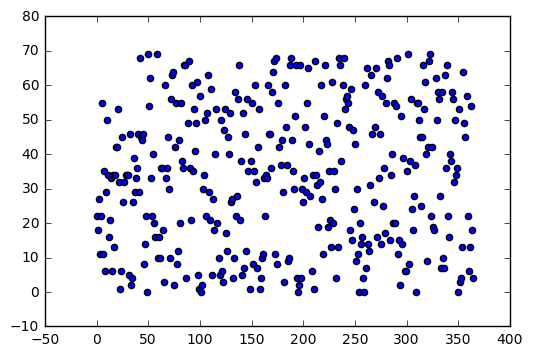

In [176]:
plt.scatter(range(365), wholesale_agent.best_policy)

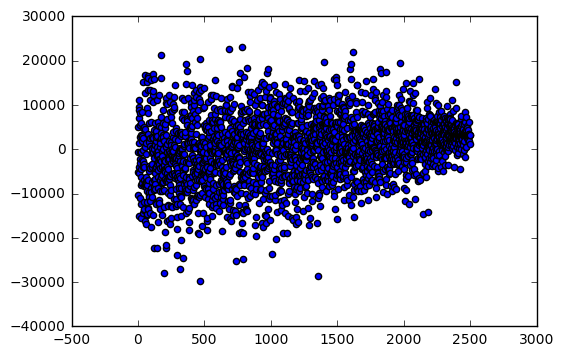

In [177]:
plt.scatter(range(len(retail_agent.historic_payout)-1), retail_agent.historic_payout[1:])

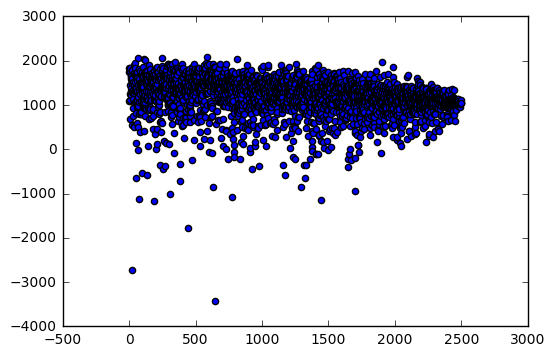

In [178]:
plt.scatter(range(len(wholesale_agent.historic_payout)-1), wholesale_agent.historic_payout[1:])

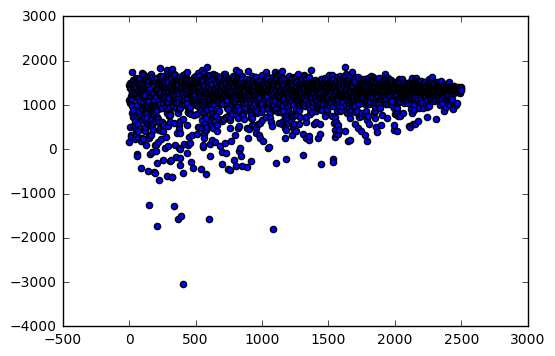

In [179]:
plt.scatter(range(len(regional_warehouse_agent.historic_payout)-1), regional_warehouse_agent.historic_payout[1:])

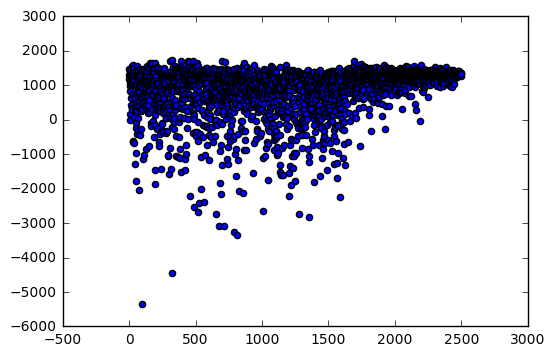

In [180]:
plt.scatter(range(len(factory_agent.historic_payout)-1), factory_agent.historic_payout[1:])

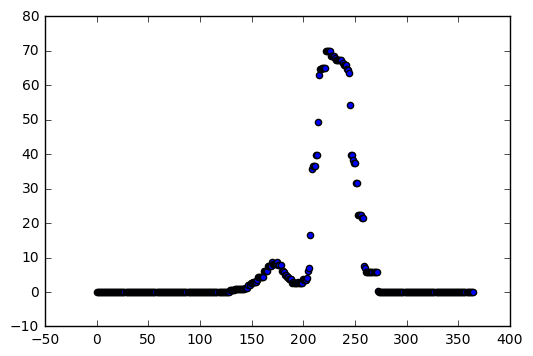

In [107]:
plt.scatter(range(365), fields_agent.supply)

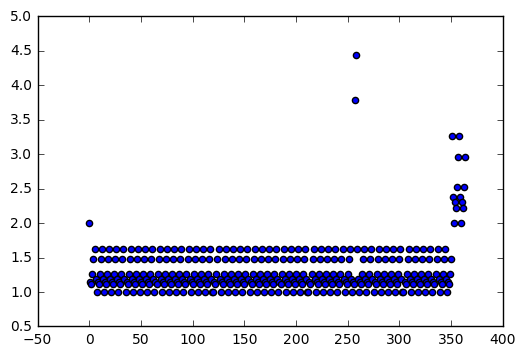

In [108]:
plt.scatter(range(365), customer_agent.demand)